In [196]:
import pandas as pd
import numpy as np
import os
import re
import json
import urllib.request
from urllib.parse import quote_plus
from datetime import datetime,timedelta
from copy import copy
from time import sleep
import matplotlib as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from copy import copy
from gnews import GNews


import selenium
from bs4 import BeautifulSoup as bs




In [166]:
def remove_special_characters(input_string):
    # This regex pattern matches any character that is not a letter or a number
    pattern = r'[^a-zA-Z0-9]'
    # Replace these characters with an empty string
    cleaned_string = re.sub(pattern, '', input_string)
    return cleaned_string

In [167]:
def save_movie(movie):
    filename = 'movie_jsons/' + remove_special_characters(movie.title).replace(' ','_') + '.json'
    df.reset_index(drop=True).to_json(filename)

In [ ]:
def remove_uncat(movie):
    df = movie.df
    movie.df = movie.df[movie.df['Uncategorized'] == False]
    return movie

In [170]:
class Movie:
    def __init__(self, title, actors, directors,release_date, gross_income, query):
        self.title = title
        self.actors = actors
        self.directors = directors
        self.release_date = release_date
        self.gross_income = gross_income
        self.query = query
        
    def load_df(self):
        filename = 'movie_jsons/' + remove_special_characters(self.title).replace(' ','_') + '.json'
        self.df = pd.read_json(filename)
        
    def get_df(self):
        print("fetching articles")
        self.fetch_articles()
        print(f"{self.df.shape[0]} Articles found")

        print("getting text")
        self.get_full_text()
        print(f"{self.df.shape[0]} Articles with full text")

        print("categorizing")
        self.categorize_articles()
        print(f"{self.df.shape[0]} Articles categorized")
    
    def fetch_articles(self):
        month_before = self.release_date - timedelta(days=30)
        month_after = self.release_date + timedelta(days=30)
        sd = (month_before.year,month_before.month,month_before.day)
        rd = (self.release_date.year,self.release_date.month,self.release_date.day)
        ed = (month_after.year,month_after.month,month_after.day)

        self.google_news = GNews(language='en', country='US', start_date=sd, end_date=ed, max_results=500)
        
        gnews1 = GNews(language='en', country='US', start_date=sd, end_date=rd, max_results=500)
        gnews2 = GNews(language='en', country='US', start_date=rd, end_date=ed, max_results=500)

        self.df = self.fetch_articles_for_keyword(gnews1,self.title)
        self.df = self.df.append(self.fetch_articles_for_keyword(gnews2,self.title))
        for a in self.actors:
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews1, a))
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews2, a))
            
        for d in self.directors:
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews1,d))
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews2,d))

        self.df = self.df.drop_duplicates(subset='url')
        self.df['text'] = ""
        
    def fetch_articles_for_keyword(self,gnews,keyword):
        df = pd.DataFrame(gnews.get_news(keyword))
        print(f"{keyword}: {df.shape[0]} Articles found")
        return df
    
    def get_full_text(self):
        for index, article in self.df.iterrows():
            if article['text'] == "":
                url = article['url']
                try:
                    # Get full article using gnews.get_full_article
                    full_article = self.google_news.get_full_article(url)

                    if full_article and hasattr(full_article, 'text'):
                        self.df.at[index, 'text'] = full_article.text
                    else:
                        pass
    #                     print(f"Could not extract text from article at {url}")
                except Exception as e:
                    pass
    #                 print(f"Error processing article at {url}: {e}\n")
                    
    
    def categorize_articles(self):
        category_keywords = {
            "Box Office Performance and Industry Impact": ["box office", "sales", "grossing", "financial", "industry impact", "ticket sales", "revenue", "economic", "market", "record-breaking", "earnings"],
            "Cultural and Social Commentary": ["cultural", "social impact", "gender roles", "feminism", "representation", "diversity", "social norms", "influence", "identity", "societal", "empowerment"],
            "Behind-the-Scenes and Production Insights": self.directors + ["behind-the-scenes", "production", "filming", "director", "cast interviews", "making of", "set design", "shooting", "cinematography", "screenplay", "script"],
            "Fashion and Aesthetics": ["fashion", "costumes", "design", "style", "aesthetics", "Barbie Pink", "wardrobe", "outfits", "makeup", "visual style", "art direction"],
            "Celebrity and Cast Focus": self.actors + ["cast", "actor", "actress", "celebrity", "interview", "performance", "star", "cast insights"],
            "Marketing and Promotional Strategies": ["marketing", "promotion", "advertising", "campaign", "trailer", "merchandise", "PR", "public relations", "branding", "launch", "premiere"],
            "Fan and Audience Reactions": ["fans", "audience", "reaction", "reviews", "social media", "memes", "hashtags", "trending", "viewership", "audience response", "feedback", "TikTok", "Twitter", "Instagram", "Facebook"],
            "Critique and Reviews": ["review", "critique", "analysis", "rating", "criticism", "opinion", "film review", "movie critique", "reception", "critical", "commentary"],
            "Merchandise and Commercial Tie-Ins": ["merchandise", "toys", "product", "commercial", "tie-in", "retail", "sales", "Barbie doll", "collectibles", "brand partnership", "licensed"],
            "Global and Political Perspectives": ["global", "international", "political", "controversy", "ban", "censorship", "cross-cultural", "diplomacy", "worldwide", "geopolitical", "policy"]
        }
        
        for category, keywords in category_keywords.items():
            self.df[category] = False
        self.df['Uncategorized'] = False
        
        for index, row in self.df.iterrows():
            c_count = 0
            for category, keywords in category_keywords.items():
                if any(keyword in row['text'] for keyword in keywords):
                    c_count += 1
                    self.df.at[index, category] = True
            if c_count == 0:
                self.df.at[index, 'Uncategorized'] = True

                

            

In [186]:
ba = ["Margot Robbie", "Ryan Gosling"]
bd = ["Greta Gerwig"]
br = datetime(2023, 7, 21)
bgi = 1441000000
bq = 'Barbie AND ("Barbie Movie" OR "Margot Robbie" OR "Barbenheimer" OR "Greta Gerwig")'
barbie_movie = Movie('Barbie',ba,bd,br,bgi,bq)
barbie_movie.get_df()
# barbie_movie.load_df()

fetching articles
Barbie: 91 Articles found
Barbie: 94 Articles found
Margot Robbie: 93 Articles found
Margot Robbie: 97 Articles found
Ryan Gosling: 98 Articles found
Ryan Gosling: 95 Articles found
Greta Gerwig: 93 Articles found
Greta Gerwig: 98 Articles found
714 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/barbie-movie-ruth-handler-2f929140 on URL https://news.google.com/rss/articles/CBMiP2h0dHBzOi8vd3d3Lndzai5jb20vYXJ0aWNsZXMvYmFyYmllLW1vdmllLXJ1dGgtaGFuZGxlci0yZjkyOTE0MNIBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/barbie-movie-merch-margot-b61cca7b on URL https://news.google.com/rss/articles/CBMiP2h0dHBzOi8vd3d3Lndzai5jb20vYXJ0aWNsZXMvYmFyYmllLW1vdmllLW1lcmNoLW1hcmdvdC1iNjFjY2E3YtIBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An e

An error occurred while fetching the article: Article `download()` failed with HTTPSConnectionPool(host='news.google.com', port=443): Max retries exceeded with url: /rss/articles/CBMiNGh0dHBzOi8vbW92aWV3ZWIuY29tL2JhcmJpZS1tb3ZpZS1iZXN0LXBlcmZvcm1hbmNlcy_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fb220114c40>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')) on URL https://news.google.com/rss/articles/CBMiNGh0dHBzOi8vbW92aWV3ZWIuY29tL2JhcmJpZS1tb3ZpZS1iZXN0LXBlcmZvcm1hbmNlcy_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with HTTPSConnectionPool(host='news.google.com', port=443): Max retries exceeded with url: /rss/articles/CBMiWWh0dHBzOi8vd3d3LmF3YXJkc2RhaWx5LmNvbS8yMDIzLzA4LzE4LzIwMjQtb3NjYXItcHJlZGljdGlvbnMtaXMtdGhpcy1ncmV0YS1nZXJ3aWdzLXllYXIv0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en (Caused by NewConnectionEr

In [203]:
opa = ["Cillian Murphy","Florence Pugh"]
opd = ["Christopher Nolan"]
opr = datetime(2023, 7, 21)
opgi = 890000000
opp_movie = Movie('Oppenheimer',opa,opd,opr,opgi,"")
opp_movie.get_df()
# opp_movie.load_df()

fetching articles
Oppenheimer: 91 Articles found
Oppenheimer: 91 Articles found
Cillian Murphy: 96 Articles found
Cillian Murphy: 97 Articles found
Florence Pugh: 90 Articles found
Florence Pugh: 93 Articles found
Christopher Nolan: 95 Articles found
Christopher Nolan: 94 Articles found
698 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/simonthompson/2023/07/19/why-playing-oppenheimer-left-cillian-murphy-exhausted-but-very-satisfied/ on URL https://news.google.com/rss/articles/CBMif2h0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvc2ltb250aG9tcHNvbi8yMDIzLzA3LzE5L3doeS1wbGF5aW5nLW9wcGVuaGVpbWVyLWxlZnQtY2lsbGlhbi1tdXJwaHktZXhoYXVzdGVkLWJ1dC12ZXJ5LXNhdGlzZmllZC_SAYMBaHR0cHM6Ly93d3cuZm9yYmVzLmNvbS9zaXRlcy9zaW1vbnRob21wc29uLzIwMjMvMDcvMTkvd2h5LXBsYXlpbmctb3BwZW5oZWltZXItbGVmdC1jaWxsaWFuLW11cnBoeS1leGhhdXN0ZWQtYnV0LXZlcnktc2F0aXNmaWVkL2FtcC8?oc=5&hl=en-CA&gl=CA

In [204]:
mia = ["Tom Cruise","Hayley Atwell"]
mid = ["Christopher McQuarrie"]
mir = datetime(2023, 7, 12)
migi = 567500000
miq = '("Mission: Impossible 7" OR "Mission: Impossible – Dead Reckoning Part One" "Mission Impossible") AND ("Dead Reckoning" OR "Tom Cruise" OR "Christopher McQuarrie")'
mi_movie = Movie('Mission: Impossible',mia,mid,mir,migi,miq)
mi_movie.get_df()
# mi_movie.load_df()

fetching articles
Mission: Impossible: 97 Articles found
Mission: Impossible: 95 Articles found
Tom Cruise: 97 Articles found
Tom Cruise: 98 Articles found
Hayley Atwell: 98 Articles found
Hayley Atwell: 98 Articles found
Christopher McQuarrie: 99 Articles found
Christopher McQuarrie: 96 Articles found
667 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with HTTPSConnectionPool(host='www.menshealth.com', port=443): Read timed out. (read timeout=7) on URL https://news.google.com/rss/articles/CBMic2h0dHBzOi8vd3d3Lm1lbnNoZWFsdGguY29tL2VudGVydGFpbm1lbnQvYTQ0NDYwOTAxL3RvbS1jcnVpc2UtYmlnZ2VzdC1zdHVudC1ldmVyLW1pc3Npb24taW1wb3NzaWJsZS1kZWFkLXJlY2tvbmluZy_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiTWh0dHBzOi8vc2NyZWVucmFudC5jb20vbWl

An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiX2h0dHBzOi8vc2NyZWVucmFudC5jb20vbWlzc2lvbi1pbXBvc3NpYmxlLTctZW50aXR5LXZpbGxhaW4tY2hyaXN0b3BoZXItbWNxdWFycmllLWFpLWNvbXBhcmlzb24v0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiS2h0dHBzOi8vc2NyZWVucmFudC5jb20vbWlzc2lvbi1pbXBvc3NpYmxlLTctaWxzYS1kZWF0aC11bmRvLXJ1aW4tZnJhbmNoaXNlL9IBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://fayettevilleflyer.com/2023/07/14/cruise-keeps-thrills-alive-with-7th-mission-impossible-film/ on URL https://news.google.com/rss/artic

12/11/2023 12:09:59 PM - newspaper ignoring lxml node error: Input object is not an XML element: HtmlProcessingInstruction


An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiN2h0dHBzOi8vY29sbGlkZXIuY29tL21pc3Npb24taW1wb3NzaWJsZS1hbmdlbGEtYmFzc2V0dC_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiQWh0dHBzOi8vc2NyZWVucmFudC5jb20vYnJhZC1waXR0LWYxLXJhY2luZy1tb3ZpZS10b20tY3J1aXNlLWNvcHkv0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiYmh0dHBzOi8vd3d3LnRoZXRoaW5ncy5jb20vc3RldmVuLXNwaWVsYmVyZy1yZXZlYWxlZC10b20tY3J1aXNlLXRvb2stY2FsbHMtZnJvb

In [205]:
kfma = ["Leonardo Dicaprio","Lily Gladstone"]
kfmd = ["Martin Scorsese"]
kfmr = datetime(2023, 10, 20)
kfmgi = 567500000
kfmq = ''
kfm_movie = Movie('Killers of the Flower Moon',kfma,kfmd,kfmr,kfmgi,kfmq)
kfm_movie.get_df()
# kfm_movie.load_df()

fetching articles
Killers of the Flower Moon: 95 Articles found
Killers of the Flower Moon: 91 Articles found
Leonardo Dicaprio: 100 Articles found
Leonardo Dicaprio: 98 Articles found
Lily Gladstone: 98 Articles found
Lily Gladstone: 97 Articles found
Martin Scorsese: 98 Articles found
Martin Scorsese: 96 Articles found
690 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiXGh0dHBzOi8vc2NyZWVucmFudC5jb20va2lsbGVycy1mbG93ZXItbW9vbi1tYXJ0aW4tc2NvcnNlc2UtY2FzdGluZy1oYWJpdHMtbGVvbmFyZG8tZGljYXByaW8v0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiXGh0dHBzOi8vd3d3LmNici5jb20va2lsbGVycy1vZi10a

/Users/yiannizavaliagkos/opt/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiT2h0dHBzOi8vc2NyZWVucmFudC5jb20vbWFydGluLXNjb3JzZXNlLW1vdmllcy13YXRjaC1iZWZvcmUta2lsbGVycy1mbG93ZXItbW9vbi_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnews.fr/culture/2023-09-25/killers-flower-moon-vu-le-film-de-martin-scorsese-avec-leonardo-dicaprio-et-voici on URL https://news.google.com/rss/articles/CBMieWh0dHBzOi8vd3d3LmNuZXdzLmZyL2N1bHR1cmUvMjAyMy0wOS0yNS9raWxsZXJzLWZsb3dlci1tb29uLXZ1LWxlLWZpbG0tZGUtbWFydGluLXNjb3JzZXNlLWF2ZWMtbGVvbmFyZG8tZGljYXByaW8tZXQtdm9pY2nSAX1odHRwczovL3d3dy5jbmV3cy5mci9jdWx0dXJlLzIwMjMtMDktMjUva2lsbGVycy1mbG93ZXItbW9vbi12dS1sZS1maWxtLWRlLW1hcnRpbi1zY29yc2VzZS1hdmVjLWxlb25hcmRvLWRpY2FwcmlvLWV0LXZvaWNpP2FtcA?oc=5&hl=en-CA&gl

In [206]:
bfgwa = ["Nia Vardalos","Elena Kampouris"]
bfgwd = ["Nia Vardalos"]
bfgwr = datetime(2023, 10, 20)
bfgwgi = 38000000
bfgw_movie = Movie('My Big Fat Greek Wedding 3',bfgwa,bfgwd,bfgwr,bfgwgi,'')
bfgw_movie.get_df()
# bfgw_movie.load_df()

fetching articles
My Big Fat Greek Wedding 3: 98 Articles found
My Big Fat Greek Wedding 3: 99 Articles found
Nia Vardalos: 98 Articles found
Nia Vardalos: 100 Articles found
Elena Kampouris: 93 Articles found
Elena Kampouris: 35 Articles found
Nia Vardalos: 98 Articles found
Nia Vardalos: 100 Articles found
464 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://greekcitytimes.com/2023/09/29/varypatades-the-village-in-my-big-fat-greek-wedding-3/ on URL https://news.google.com/rss/articles/CBMiXGh0dHBzOi8vZ3JlZWtjaXR5dGltZXMuY29tLzIwMjMvMDkvMjkvdmFyeXBhdGFkZXMtdGhlLXZpbGxhZ2UtaW4tbXktYmlnLWZhdC1ncmVlay13ZWRkaW5nLTMv0gFgaHR0cHM6Ly9ncmVla2NpdHl0aW1lcy5jb20vMjAyMy8wOS8yOS92YXJ5cGF0YWRlcy10aGUtdmlsbGFnZS1pbi1teS1iaWctZmF0LWdyZWVrLXdlZGRpbmctMy8_YW1w?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisc

In [207]:
cba = ["Ray Liotta","Keri Russell"]
cbd = ["Elizabeth Banks"]
cbr = datetime(2023, 2, 22)
cbgi = 89684427
cb_movie = Movie('Cocaine Bear',cba,cbd,cbr,cbgi,'')
cb_movie.get_df()
# cb_movie.load_df()

fetching articles
Cocaine Bear: 93 Articles found
Cocaine Bear: 95 Articles found
Ray Liotta: 94 Articles found
Ray Liotta: 100 Articles found
Keri Russell: 97 Articles found
Keri Russell: 98 Articles found
Elizabeth Banks: 96 Articles found
Elizabeth Banks: 98 Articles found
621 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with HTTPSConnectionPool(host='www.seattletimes.com', port=443): Read timed out. (read timeout=7) on URL https://news.google.com/rss/articles/CBMiZGh0dHBzOi8vd3d3LnNlYXR0bGV0aW1lcy5jb20vZW50ZXJ0YWlubWVudC9jb2NhaW5lLWJlYXItaXMtaGVyZS10by1zdHJpa2UtYS1ibG93LXRvLXN0YWlkLWhvbGx5d29vZC_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiPWh0dHBzOi8vc2NyZWVucmFudC5jb20vY29jYWluZS1iZWFyLXNlcXVlbC1zaGFyay13b3JrLXJlYXNv

In [263]:
sva = ["Ray Liotta","Keri Russell"]
svd = "Joaquim Dos Santos,Kemp Powers,Justin K. Thompson".split(sep=',')
svr = datetime(2023, 6, 2)
svgi = 682977332
sv_movie = Movie('Spider-Man: Across the Spider-Verse',sva,svd,svr,svgi,'')
sv_movie.get_df()
# sv_movie.load_df()

fetching articles
Spider-Man: Across the Spider-Verse: 77 Articles found
Spider-Man: Across the Spider-Verse: 98 Articles found
Ray Liotta: 97 Articles found
Ray Liotta: 99 Articles found
Keri Russell: 95 Articles found
Keri Russell: 95 Articles found
Joaquim Dos Santos: 94 Articles found
Joaquim Dos Santos: 97 Articles found
Kemp Powers: 95 Articles found
Kemp Powers: 99 Articles found
Justin K. Thompson: 93 Articles found
Justin K. Thompson: 98 Articles found
873 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fortnite.com/news/the-spider-verse-brings-web-shooters-miles-morales-and-more-to-fortnite?lang=en-US on URL https://news.google.com/rss/articles/CBMicGh0dHBzOi8vd3d3LmZvcnRuaXRlLmNvbS9uZXdzL3RoZS1zcGlkZXItdmVyc2UtYnJpbmdzLXdlYi1zaG9vdGVycy1taWxlcy1tb3JhbGVzLWFuZC1tb3JlLXRvLWZvcnRuaXRlP2xhbmc9ZW4tVVPSAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the a

An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiSmh0dHBzOi8vc2NyZWVucmFudC5jb20vYWNyb3NzLXRoZS1zcGlkZXItdmVyc2UtZWFzdGVyLWVnZy1lZWFhby1jb25maXJtZWQv0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiS2h0dHBzOi8vd3d3LmNici5jb20vYWNyb3NzLXRoZS1zcGlkZXItdmVyc2Utc3Rvcnlib2FyZHMtbWlsZXMtY29sbGVjdGlibGVzL9IBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiWGh0dHBzOi8vbW92aWV3ZWIuY29tL29zY2FyLWlzYWFjLW1hcnZlbC1oaXN0b3J5LX

In [218]:
movies = [barbie_movie,opp_movie,mi_movie,kfm_movie,bfgw_movie,cb_movie, sv_movie]

In [283]:
for cat in categories:
    print(cat)

Box Office Performance and Industry Impact
Cultural and Social Commentary
Behind-the-Scenes and Production Insights
Fashion and Aesthetics
Celebrity and Cast Focus
Marketing and Promotional Strategies
Fan and Audience Reactions
Critique and Reviews
Merchandise and Commercial Tie-Ins
Global and Political Perspectives


In [183]:
categories = [
    "Box Office Performance and Industry Impact",
    "Cultural and Social Commentary",
    "Behind-the-Scenes and Production Insights",
    "Fashion and Aesthetics",
    "Celebrity and Cast Focus",
    "Marketing and Promotional Strategies",
    "Fan and Audience Reactions",
    "Critique and Reviews",
    "Merchandise and Commercial Tie-Ins",
    "Global and Political Perspectives"]
movies = [remove_uncat(movie) for movie in movies]

In [162]:
[save_movie(movie) for movie in movies]

[None, None, None, None, None, None, None]

In [281]:
movie_gi = [round(movie.gross_income/1000000)*1000000 for movie in movies]
movie_scores = dict(zip(movie_names,movie_gi))

prop_df = pd.DataFrame(list(movie_scores.items()), columns=['Movie Title', 'Gross Income'])


In [282]:
prop_df

,Movie Title,Gross Income
0,Barbie,1441000000
1,Oppenheimer,890000000
2,Mission: Impossible,568000000
3,Killers of the Flower Moon,568000000
4,My Big Fat Greek Wedding 3,38000000
5,Cocaine Bear,90000000
6,Spider-Man: Across the Spider-Verse,683000000


In [250]:
article_counts = [movie.df.shape[0] for movie in movies]
cat_counts_df = pd.DataFrame(np.transpose([[round(movie.df[cat].sum()/movie.df.shape[0]*100)/100 for movie in movies] for cat in categories]))
cat_counts_df.columns = categories
movie_scores = dict(zip(movie_names,article_counts))

prop_df = pd.DataFrame(list(movie_scores.items()), columns=['Movie Title', 'Total # Articles'])


In [251]:
pd.concat([prop_df,cat_counts_df],axis=1)

,Movie Title,Total # Articles,Box Office Performance and Industry Impact,Cultural and Social Commentary,Behind-the-Scenes and Production Insights,Fashion and Aesthetics,Celebrity and Cast Focus,Marketing and Promotional Strategies,Fan and Audience Reactions,Critique and Reviews,Merchandise and Commercial Tie-Ins,Global and Political Perspectives
0,Barbie,714,0.50,0.33,0.60,0.65,0.84,0.65,0.53,0.46,0.61,0.49
1,Oppenheimer,698,0.31,0.15,0.85,0.27,0.80,0.38,0.60,0.41,0.27,0.54
2,Mission: Impossible,667,0.29,0.06,0.70,0.18,0.94,0.39,0.59,0.26,0.33,0.24
3,Killers of the Flower Moon,690,0.23,0.17,0.85,0.19,0.82,0.39,0.26,0.31,0.25,0.37
4,My Big Fat Greek Wedding 3,464,0.30,0.09,0.38,0.16,0.79,0.32,0.42,0.35,0.22,0.38
5,Cocaine Bear,621,0.19,0.11,0.63,0.15,0.77,0.46,0.41,0.23,0.29,0.36
6,Spider-Man: Across the Spider-Verse,874,0.18,0.15,0.44,0.32,0.67,0.47,0.60,0.22,0.19,0.26


In [237]:
article_counts = [movie.df.shape[0] for movie in movies]
cat_counts_df = pd.DataFrame(np.transpose([[movie.df[cat].sum() for movie in movies] for cat in categories]))
cat_counts_df.columns = categories
movie_scores = dict(zip(movie_names,article_counts))

count_df = pd.DataFrame(list(movie_scores.items()), columns=['Movie Title', 'Total # Articles'])

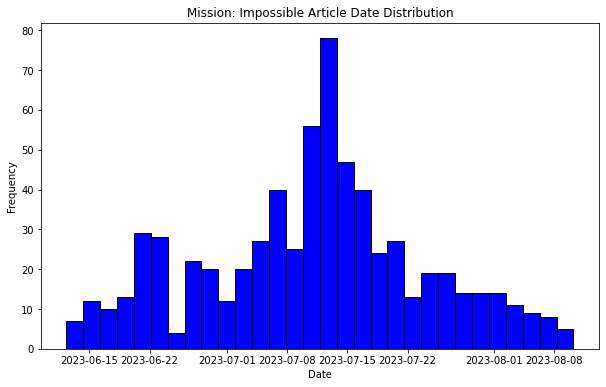

In [286]:
m = mi_movie
df = m.df
df['published date'] = pd.to_datetime(df['published date'])

# Create a histogram of the date distribution
plt.pyplot.figure(figsize=(10, 6))
plt.pyplot.hist(df['published date'], bins=30, color='blue', edgecolor='black')
plt.pyplot.xlabel('Date')
plt.pyplot.ylabel('Frequency')
plt.pyplot.title(f'{m.title} Article Date Distribution')
plt.pyplot.show()

In [252]:
barbie_movie.df

,title,description,published date,url,publisher,text,Box Office Performance and Industry Impact,Cultural and Social Commentary,Behind-the-Scenes and Production Insights,Fashion and Aesthetics,Celebrity and Cast Focus,Marketing and Promotional Strategies,Fan and Audience Reactions,Critique and Reviews,Merchandise and Commercial Tie-Ins,Global and Political Perspectives,Uncategorized
0,'Barbie' filmmaker Greta Gerwig wants to embra...,'Barbie' filmmaker Greta Gerwig wants to embra...,"Thu, 20 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiWWh0d...,"{'href': 'https://apnews.com', 'title': 'The A...","Barbie, the doll, may be 64 years old, but “Ba...",True,False,True,False,True,False,True,True,False,False,False
1,‘Barbie’ delivers a feminist message dressed u...,‘Barbie’ delivers a feminist message dressed u...,"Fri, 21 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiRWh0d...,"{'href': 'https://www.cnn.com', 'title': 'CNN'}",CNN —\n\n“Barbie” comes roaring out of the gat...,True,False,True,False,True,True,True,False,False,True,False
2,'Barbie' Review: Out of the Box and On the Roa...,'Barbie' Review: Out of the Box and On the Roa...,"Fri, 21 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiQmh0d...,"{'href': 'https://www.nytimes.com', 'title': '...",Gerwig carves a comic pathway into these repre...,False,True,True,False,True,False,False,False,False,False,False
3,Box Office: ‘Barbie’ Heads for $100 Million Br...,Box Office: ‘Barbie’ Heads for $100 Million Br...,"Tue, 18 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiZWh0d...,"{'href': 'https://variety.com', 'title': 'Vari...","“Barbenheimer” is officially here, and the bat...",True,False,True,False,True,True,True,False,True,True,False
4,"“Oppenheimer” and “Barbie,” Reviewed - The New...","“Oppenheimer” and “Barbie,” Reviewed The New ...","Thu, 20 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiTWh0d...,"{'href': 'https://www.newyorker.com', 'title':...","The new film from Christopher Nolan, “Oppenhei...",False,False,True,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,California's First Murder Conviction for Fenta...,California's First Murder Conviction for Fenta...,"Thu, 03 Aug 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMingFod...,"{'href': 'https://www.capradio.org', 'title': ...",Greta Gerwig’s ravenously anticipated Barbie m...,False,True,True,True,True,False,True,False,False,False,False
94,Million-dollar Barbie collection grows as Sacr...,Million-dollar Barbie collection grows as Sacr...,"Wed, 26 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiwwFod...,"{'href': 'https://www.abc10.com', 'title': 'AB...",,False,False,False,False,False,False,False,False,False,False,True
95,Barbie: 11 Best Performances in Greta Gerwig's...,Barbie: 11 Best Performances in Greta Gerwig's...,"Mon, 31 Jul 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiNGh0d...,"{'href': 'https://movieweb.com', 'title': 'Mov...",,False,False,False,False,False,False,False,False,False,False,True
96,2024 Oscar Predictions – Is This Greta Gerwig'...,2024 Oscar Predictions – Is This Greta Gerwig'...,"Fri, 18 Aug 2023 07:00:00 GMT",https://news.google.com/rss/articles/CBMiWWh0d...,"{'href': 'https://www.awardsdaily.com', 'title...",,False,False,False,False,False,False,False,False,False,False,True


In [245]:
pd.concat([count_df,cat_counts_df],axis=1)

,Movie Title,Total # Articles,Box Office Performance and Industry Impact,Cultural and Social Commentary,Behind-the-Scenes and Production Insights,Fashion and Aesthetics,Celebrity and Cast Focus,Marketing and Promotional Strategies,Fan and Audience Reactions,Critique and Reviews,Merchandise and Commercial Tie-Ins,Global and Political Perspectives
0,Barbie,714,355,236,429,466,597,466,381,327,434,347
1,Oppenheimer,698,217,102,593,190,561,264,420,289,186,376
2,Mission: Impossible,667,196,37,465,122,626,259,396,173,222,163
3,Killers of the Flower Moon,690,161,117,589,132,565,270,179,212,172,253
4,My Big Fat Greek Wedding 3,464,141,42,175,74,367,150,197,164,101,178
5,Cocaine Bear,621,116,66,391,95,478,287,257,140,177,225
6,Spider-Man: Across the Spider-Verse,874,153,132,388,282,583,414,527,194,167,224


In [180]:
category_counts = [movie.df[list(categories)].sum() for movie in movies]
movie_names = [movie.title for movie in movies]

# Create a DataFrame from the counts
data = dict(zip(movie_names,category_counts))
df = pd.DataFrame(data)


ax = df.plot(kind='bar', figsize=(14, 8))

# Adding titles and labels using the ax object
ax.set_title('Category Counts Comparison between Movies')
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.pyplot.tight_layout()
plt.pyplot.savefig('category_counts.png',facecolor='white', transparent=False)

KeyError: "None of [Index(['Box Office Performance and Industry Impact',\n       'Cultural and Social Commentary',\n       'Behind-the-Scenes and Production Insights', 'Fashion and Aesthetics',\n       'Celebrity and Cast Focus', 'Marketing and Promotional Strategies',\n       'Fan and Audience Reactions', 'Critique and Reviews',\n       'Merchandise and Commercial Tie-Ins',\n       'Global and Political Perspectives'],\n      dtype='object')] are in the [columns]"

In [120]:
def get_percentage_box_office(movie, col_name):
    df = movie.df
    num_true = df[col_name].sum()
    total = df[col_name].count()
    return num_true/total

In [164]:
percentages_list = [[get_percentage_box_office(movie,cat) for movie in movies] for cat in categories]
gross_income = [movie.gross_income for movie in movies]
movie_names = [movie.title for movie in movies]

# Create and save each subplot as an individual figure
for i, percentages in enumerate(percentages_list):
    fig, ax = plt.pyplot.subplots(figsize=(10, 6))
    ax.scatter(gross_income, percentages)
    ax.set_title(f"Set {i + 1}: {categories[i]} vs Movie Gross Income")
    ax.set_xlabel("Gross Income (in millions)")
    ax.set_ylabel("Percentage of Box Office Articles (%)")
    for j, name in enumerate(movie_names):
        ax.annotate(name, (gross_income[j], percentages[j]))
    
    # Save each figure
    plt.pyplot.savefig(f"yianni_imgs/{categories[i].replace(' ','_')}.png",facecolor='white', transparent=False)  # Change the path and filename as needed
    plt.pyplot.close(fig)  # Close the figure to free up memory

'Global_and_Political_Perspectives'

In [163]:
percentage_of_box_office_articles = [get_percentage_box_office(movie) for movie in movies]
gross_income = [movie.gross_income for movie in movies]
movie_names = [movie.title for movie in movies]

plt.pyplot.figure(figsize=(10, 6))
plt.pyplot.scatter(gross_income, percentage_of_box_office_articles)

# Adding labels and title
plt.pyplot.title(f"{categories[i]} vs Movie Gross Income")
plt.pyplot.xlabel("Gross Income (in millions)")
plt.pyplot.ylabel("Percentage of Box Office Articles (%)")

# Annotating each point with the movie name
for i, name in enumerate(movie_names):
    plt.pyplot.annotate(name, (gross_income[i], percentage_of_box_office_articles[i]))

plt.pyplot.show()


TypeError: get_percentage_box_office() missing 1 required positional argument: 'col_name'